In [192]:
import os
import subprocess
import time
import sys
import pandas as pd
import random
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def parse_clean_annot(file):
    try:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1", "ec2", "ec3", "ec4", "ec5", "ec6", "ec7", "ec8", "ec9", "ec10"]).dropna(axis = 1, how = "all")
    except pd.errors.ParserError:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1"])
    data["ec"] = [mappings[0].replace("EC:", "") for mappings in data["ec1"].str.split("/")]
    data["confidence_ec1"] = [float(mappings[1]) for mappings in data["ec1"].str.split("/")]
    return data

In [3]:
pid2eclabel_df = pd.read_csv("/data/tobiassonva/data/databases/reviewed_EC_numbers/uniprotkb_reviewed_and_published_with_EC.tsv", sep = "\t")
pid2eclabel_df.rename(columns = {"Entry": "Query", "EC number" : "EC_label"}, inplace = True)

In [4]:
proteinfer_swarmfile = "/data/luojaa/proteinfer/benchmark/uniprot/OUTPUT/tmp/reannotate_proteinfer.swarm"
ordered_infiles = []
with open(proteinfer_swarmfile, "r") as f:
    lines = f.readlines()
    for line in lines[6:]:
        ordered_infiles.append(line.strip().split(" ")[4].split("/")[-1].strip(".fasta"))

ordered_kogs = [file.split(".")[1] for file in ordered_infiles]

output_csvs = [f"/data/luojaa/CLEAN_processing/uniprot/OUTPUT/{file}_maxsep.csv" for file in ordered_infiles]


In [5]:
def calc_stats(df, ec, ec_pos):
    ec = ".".join(ec.split(".")[:ec_pos])
    label, pred = df.EC_label.apply(lambda x: ".".join(x.split(".")[:ec_pos])), df.EC.apply(lambda x: ".".join(x.split(".")[:ec_pos]))
    num_members = len(set(df[label == ec].Query))
    TP = len(set(df[(label == pred) & (label == ec)].Query))
    FP = len(set(df[label != ec].Query))
    FN = num_members - TP
#     if TP == 0:
#         return ["0","0"]
#     sensitivity = TP / (TP + FN)
#     precision = TP / (TP + FP)
    return ",".join([ec, str(TP), str(FP), str(FN)])


In [6]:
def calc_stats_all(eval_dfs, fullec):
    stats_nested = [calc_stats(eval_dfs[0], fullec, 1), calc_stats(eval_dfs[1], fullec, 2), calc_stats(eval_dfs[2], fullec, 3), calc_stats(eval_dfs[3], fullec, 4)]
    for stats in stats_nested:
        print(stats)

def calc_correlations(df, ec, ec_pos):
    ec = ".".join(ec.split(".")[:ec_pos])
    label, pred = df.EC_label.apply(lambda x: ".".join(x.split(".")[:ec_pos])), df.EC.apply(lambda x: ".".join(x.split(".")[:ec_pos]))
    num_members = len(set(df[label == ec].Query))
    TP = len(set(df[(label == pred) & (label == ec)].Query))
    FP = len(set(df[label != ec].Query))
    FN = num_members - TP
    conf_avg = np.mean([float(conf) for conf in list(df.confidence)])
    if TP == 0:
        return [ec, 0, 0, conf_avg]
    sensitivity = TP / (TP + FN)
    precision = TP / (TP + FP)
    return [ec, sensitivity, precision, conf_avg]


def calc_correlations_all(eval_dfs, fullec):
    stats_nested = [calc_correlations(eval_dfs[0], fullec, 1), calc_correlations(eval_dfs[1], fullec, 2), calc_correlations(eval_dfs[2], fullec, 3), calc_correlations(eval_dfs[3], fullec, 4)]
    return stats_nested
        


### clean scores

In [7]:
def parse_clean(file):
    kog_dom = file.split("/")[-1].split(".")[1].strip("_maxsep")
    kog = kog_dom.split("_")[0]
    try:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1", "ec2", "ec3", "ec4", "ec5", "ec6", "ec7", "ec8", "ec9", "ec10"]).dropna(axis = 1, how = "all")
    except pd.errors.ParserError:
        data = pd.read_csv(file, sep=',', index_col=0, names=["protein_acc", "ec1"])
    # get list of ecs each protein is annotated by
    rows = [data.loc[ind] for ind in data.index.tolist()]
    data["ecs"] = ["|".join([row.iloc[colind].split("/")[0].replace("EC:", "") for colind in range(sum(~row.isnull()))]) for row in rows]
    data["confidences"] = ["|".join([row.iloc[colind].split("/")[1] for colind in range(sum(~row.isnull()))]) for row in rows]
    
    #top ec summary stats
    data["ec"] = [mappings[0].replace("EC:", "") for mappings in data["ec1"].str.split("/")]
    data["confidence_ec1"] = [float(mappings[1]) for mappings in data["ec1"].str.split("/")]
    data["KOGID"] = [kog]*len(data)
    data["KOG_DOM"] = [kog_dom]*len(data)
    return data

In [8]:
# concat all dfs for regrouping
clean_benchmark_dfs = []
for i in range(len(output_csvs)):
    clean_output_df = parse_clean(output_csvs[i]).reset_index().rename(columns = {"predicted_label":"EC"})
    clean_output_df["Query"] = clean_output_df.protein_acc.apply(lambda x: x.split("|")[1])
    clean_benchmark_dfs.append(pd.merge(pid2eclabel_df, clean_output_df, on = "Query", how = "inner")[["Query","EC_label","ecs","ec1","confidences"]])
clean_benchmark_concat = pd.concat(clean_benchmark_dfs).drop_duplicates().dropna()
clean_benchmark_concat["EC"] = clean_benchmark_concat.ecs.str.split("|")
clean_benchmark_concat["confidence"] = clean_benchmark_concat.confidences.str.split("|")
clean_benchmark_concat = clean_benchmark_concat.explode(["EC", "confidence"])

In [9]:
clean_benchmark_concat_singlelabel = clean_benchmark_concat[~clean_benchmark_concat.EC_label.str.contains(";")].sort_values(["EC_label", "Query"])
ordered_ec_labels_clean = list(clean_benchmark_concat_singlelabel.EC_label.drop_duplicates())

In [10]:
# tmp = subset_clean_df("K15634_euk", "5.4.2.11", clean_benchmark_concat)
# tmp_eval = explode_ecs_cleandf(tmp)
# calc_stats_all(tmp_eval, "5.4.2.11", "K15634_euk")

In [11]:
def subset_clean_df(ec_label, position, df):
    ec_label = ".".join(ec_label.split(".")[:position])
    return df[(df.EC.apply(lambda x: ".".join(x.split(".")[:position])) == ec_label) | (df.EC_label.apply(lambda x: ".".join(x.split(".")[:position])) == ec_label)].reset_index().drop("index", axis = 1)

In [12]:
# correlations_nested_c = []
# for ec_label in ordered_ec_labels_clean:
#     clean_subset1 = subset_clean_df(ec_label, 1, clean_benchmark_concat_singlelabel)
#     clean_subset2 = subset_clean_df(ec_label, 2, clean_benchmark_concat_singlelabel)
#     clean_subset3 = subset_clean_df(ec_label, 3, clean_benchmark_concat_singlelabel)
#     clean_subset4 = subset_clean_df(ec_label, 4, clean_benchmark_concat_singlelabel)
#     eval_dfs = [clean_subset1, clean_subset2, clean_subset3, clean_subset4]
#     #calc_stats_all(eval_dfs, ec_label)
#     correlations_nested_c += calc_correlations_all(eval_dfs, ec_label)

In [13]:
# correlations_c_df = pd.DataFrame(correlations_nested_c, columns = ["EC", "sensitivity", "ppv", "avgconf"]).drop_duplicates()
# correlations_c_df["ec_level"] = correlations_c_df.EC.apply(lambda x: len(x.split(".")))
# correlations_c_df["group"] = correlations_c_df.EC.apply(lambda x: x[0])

# for group in range(1,8):
#     group = str(group)
#     plt.figure()
#     fig, ax = plt.subplots(figsize=(6, 6))
#     for eclevel in range(1,5):
#         df = correlations_c_df[(correlations_c_df.ec_level == eclevel) & (correlations_c_df.group == group)]
#         sns.regplot(data=df, x="sensitivity", y="avgconf", label = str(eclevel))
#     desc = group2desc[group]
#     ax.set(ylabel='average confidence', xlabel='sensitivity', title = f"Clean, group {group}: {desc}")
#     ax.legend(loc = "lower right")
#     plt.ylim(0,1)
#     plt.show()
    
# for group in range(1,8):
#     group = str(group)
#     plt.figure()
#     fig, ax = plt.subplots(figsize=(6, 6))
#     for eclevel in range(1,5):
#         df = correlations_c_df[(correlations_c_df.ec_level == eclevel) & (correlations_c_df.group == group)]
#         sns.regplot(data=df, x="ppv", y="avgconf", label = str(eclevel))
#     desc = group2desc[group]
#     ax.set(ylabel='average confidence', xlabel='ppv', title = f"Clean, group {group}: {desc}")
#     ax.legend(loc = "lower right")
#     plt.ylim(0,1)
#     plt.show()


In [14]:
# read in csv
uniprot_stats_c = pd.read_csv("clean_stats.uniprot.csv").drop_duplicates().reset_index().drop("index", axis = 1)
uniprot_stats_c["ec_level"] = uniprot_stats_c.EC.apply(lambda x: len(x.split(".")))
uniprot_stats_c["group"] = uniprot_stats_c.EC.apply(lambda x: x[0])

uniprot_stats_c_summary = uniprot_stats_c.groupby(["group", "ec_level"])[["TP", "FP", "FN"]].sum().reset_index()
uniprot_stats_c_summary["sensitivity"] = uniprot_stats_c_summary.TP / (uniprot_stats_c_summary.TP + uniprot_stats_c_summary.FN)
uniprot_stats_c_summary["ppv"] = uniprot_stats_c_summary.TP / (uniprot_stats_c_summary.TP + uniprot_stats_c_summary.FP)

uniprot_stats_c_summary["eclevel_method"] = uniprot_stats_c_summary.ec_level.apply(lambda x: str(x) + "_clean")


### proteinfer scores

In [15]:
output_tsvs = [f"/data/luojaa/proteinfer/benchmark/uniprot/OUTPUT/{file}.tsv" for file in ordered_infiles]

In [16]:
def parse_proteinfer(file):
    data = pd.read_csv(file, sep='\t', index_col=0)
    
    data[['label_type', 'predicted_label']] = [label.split(':') for label in data.predicted_label]

    data_pfam = data[data.label_type == 'Pfam']
    data_EC = data[data.label_type == 'EC'].reset_index()
    if len(data_EC) == 0:
        return
    data_GO = data[data.label_type == 'GO']
    
    #data_EC = data_EC.reset_index().drop_duplicates('sequence_name', keep='last').set_index('sequence_name')
    #data_EC['defined_EC'] = [True if label[-1] != '-' else False for label in data_EC.predicted_label]
    
    # track which rows are essentially duplicates with less detail
    data_EC["next_row_more_detail"] = pd.Series(list(data_EC.predicted_label.apply(lambda x: x.count("-")))) > pd.Series(list(data_EC.predicted_label.apply(lambda x: x.count("-")))[1:] + [5])
    data_EC["next_row_same_query"] = pd.Series(list(data_EC.sequence_name)) == pd.Series(list(data_EC.sequence_name)[1:] + ["last_row_false"])
    data_EC["next_row_same_class"] = pd.Series(list(data_EC.predicted_label.apply(lambda x: x.replace("-", "").replace(".", "")))) == pd.Series(list(data_EC.predicted_label.apply(lambda x: "".join(x.replace("-", "").strip(".").split(".")[:-1])))[1:] + ["last_row_false"])
    
#     kog_dom = file.split("/")[-1].split(".")[1].strip("_maxsep")
#     kog = kog_dom.split("_")[0]
#     data_EC["KOGID"] = [kog]*len(data_EC)
#     data_EC["KOG_DOM"] = [kog_dom]*len(data_EC)
    return data_EC[~(data_EC.next_row_more_detail & data_EC.next_row_same_query & data_EC.next_row_same_class)]

In [17]:
# concat all dfs for regrouping
pinfer_benchmark_dfs = []
for i in range(len(output_tsvs)):
    try:
        pinfer_output_df = parse_proteinfer(output_tsvs[i]).rename(columns = {"predicted_label":"EC"})
        pinfer_output_df["Query"] = pinfer_output_df["sequence_name"].apply(lambda x: x.split("|")[1])
        pinfer_benchmark_dfs.append(pd.merge(pid2eclabel_df, pinfer_output_df, on = "Query", how = "inner")[["Query","EC","EC_label","confidence"]])
    except AttributeError:
        # no ECs were annotatable in the proteins in this KOG
        pass
pinfer_benchmark_concat = pd.concat(pinfer_benchmark_dfs).drop_duplicates().dropna()

In [18]:
pinfer_benchmark_concat_singlelabel = pinfer_benchmark_concat[~pinfer_benchmark_concat.EC_label.str.contains(";")].sort_values(["EC_label", "Query"])
ordered_ec_labels_pinfer = list(pinfer_benchmark_concat_singlelabel.EC_label.drop_duplicates())

In [19]:
def subset_pinfer_df(ec_label, position, df):
    ec_label = ".".join(ec_label.split(".")[:position])
    return df[(df.EC.apply(lambda x: ".".join(x.split(".")[:position])) == ec_label) | (df.EC_label.apply(lambda x: ".".join(x.split(".")[:position])) == ec_label)].reset_index().drop("index", axis = 1)

In [20]:
# # correlations_nested_p = []
# # for ec_label in ordered_ec_labels_pinfer:
# #     pinfer_subset1 = subset_pinfer_df(ec_label, 1, pinfer_benchmark_concat_singlelabel)
# #     pinfer_subset2 = subset_pinfer_df(ec_label, 2, pinfer_benchmark_concat_singlelabel)
# #     pinfer_subset3 = subset_pinfer_df(ec_label, 3, pinfer_benchmark_concat_singlelabel)
# #     pinfer_subset4 = subset_pinfer_df(ec_label, 4, pinfer_benchmark_concat_singlelabel)
# #     eval_dfs = [pinfer_subset1, pinfer_subset2, pinfer_subset3, pinfer_subset4]
# #     #calc_stats_all(eval_dfs, ec_label)
# #     correlations_nested_p += calc_correlations_all(eval_dfs, ec_label)
    
# correlations_p_df = pd.DataFrame(correlations_nested_p, columns = ["EC", "sensitivity", "ppv", "avgconf"]).drop_duplicates()
# correlations_p_df["ec_level"] = correlations_p_df.EC.apply(lambda x: len(x.split(".")))
# correlations_p_df["group"] = correlations_p_df.EC.apply(lambda x: x[0])

# for group in range(1,8):
#     group = str(group)
#     plt.figure()
# #     fig, ax = plt.subplots(figsize=(6, 6))
#     df = correlations_p_df[correlations_p_df.group == group]
#     g = sns.jointplot(data=df, x="sensitivity", y="avgconf", hue = "ec_level")
#     sns.scatterplot(data=df, x="sensitivity", y="avgconf", hue = "ec_level", ax=g.ax_joint)
#     desc = group2desc[group]
#     plt.ylabel('average confidence')
#     plt.xlabel('sensitivity')
#     plt.legend(loc = "lower right")
#     plt.ylim(0,1)
    
# # for group in range(1,8):
# #     group = str(group)
# #     plt.figure()
# #     fig, ax = plt.subplots(figsize=(6, 6))
# #     for eclevel in range(1,5):
# #         df = correlations_p_df[(correlations_p_df.ec_level == eclevel) & (correlations_p_df.group == group)]
# #         sns.regplot(data=df, x="ppv", y="avgconf", label = str(eclevel))
# #     desc = group2desc[group]
# #     ax.set(ylabel='average confidence', xlabel='ppv', title = f"Pinfer, group {group}: {desc}")
# #     ax.legend(loc = "lower right")
# #     plt.ylim(0,1)
# #     plt.show()


In [21]:
# read in csv
uniprot_stats_p = pd.read_csv("pinfer_stats.uniprot.tsv", sep = "\t").drop_duplicates().reset_index().drop("index", axis = 1)
uniprot_stats_p["ec_level"] = uniprot_stats_p.EC.apply(lambda x: len(x.split(".")))
uniprot_stats_p["group"] = uniprot_stats_p.EC.apply(lambda x: x[0])
uniprot_stats_p

,EC,TP,FP,FN,ec_level,group
0,1,476,9,0,1,1
1,1.-,4,23,1,2,1
2,1.-.-,4,23,1,3,1
3,1.-.-.-,4,23,1,4,1
4,1.1,152,5,4,2,1
...,...,...,...,...,...,...
1474,7.4.2.-,0,0,1,4,7
1475,7.6,8,0,2,2,7
1476,7.6.2,8,0,2,3,7
1477,7.6.2.-,0,0,2,4,7


In [22]:
uniprot_stats_p_summary = uniprot_stats_p.groupby(["group", "ec_level"])[["TP", "FP", "FN"]].sum().reset_index()
uniprot_stats_p_summary["sensitivity"] = uniprot_stats_p_summary.TP / (uniprot_stats_p_summary.TP + uniprot_stats_p_summary.FN)
uniprot_stats_p_summary["ppv"] = uniprot_stats_p_summary.TP / (uniprot_stats_p_summary.TP + uniprot_stats_p_summary.FP)
uniprot_stats_p_summary["eclevel_method"] = uniprot_stats_p_summary.ec_level.apply(lambda x: str(x) + "_pinfer")


### consensus analysis

In [23]:
clean_consensus = clean_benchmark_concat_singlelabel[["Query", "EC_label", "EC", "confidence"]].sort_values(["Query", "confidence"], ascending = False).drop_duplicates("Query").rename(columns={"confidence":"clean_confidence"})
pinfer_consensus = pinfer_benchmark_concat_singlelabel[["Query", "EC_label", "EC", "confidence"]].sort_values(["Query", "confidence"], ascending = False).drop_duplicates("Query").rename(columns={"confidence":"pinfer_confidence"})
merged_consensus = pd.merge(clean_consensus, pinfer_consensus, on = "Query", how = "outer")
merged_consensus.fillna({"EC_label_x": "0.0.0.0", "EC_label_y": "0.0.0.0", "EC_x": "0.0.0.0", "EC_y": "0.0.0.0", "clean_confidence": 0, "pinfer_confidence": 0}, inplace = True)
merged_consensus["pinfer_confidence"] = merged_consensus["pinfer_confidence"].astype(float)
merged_consensus["clean_confidence"] = merged_consensus["clean_confidence"].astype(float)
merged_consensus


,Query,EC_label_x,EC_x,clean_confidence,EC_label_y,EC_y,pinfer_confidence
0,A0A023I7E1,3.2.1.39,3.2.1.6,0.8386,3.2.1.39,3.2.1.-,1.0
1,A0A024SC78,3.1.1.74,3.1.1.74,0.9968,3.1.1.74,3.1.1.74,1.0
2,A0A059TC02,1.2.1.44,1.2.1.44,0.9984,1.2.1.44,1.-.-.-,1.0
3,A0A075TRK9,1.1.-.-,4.2.1.143,0.9631,1.1.-.-,1.1.-.-,1.0
4,A0A0A1HA03,2.4.1.360,2.4.1.360,0.9970,2.4.1.360,2.4.1.-,1.0
...,...,...,...,...,...,...,...
3720,V5YM14,3.4.14.-,3.5.2.6,0.0096,3.4.14.-,3.4.14.-,1.0
3721,V9M2S5,3.2.2.6,3.2.2.6,0.1992,0.0.0.0,0.0.0.0,0.0
3722,W0T9X4,2.7.11.1,2.7.11.1,0.9912,2.7.11.1,2.7.11.1,1.0
3723,W3VKA4,3.1.1.3,3.1.1.3,0.9757,3.1.1.3,3.1.1.3,1.0


In [24]:
def get_ec(x, pos):
    return ".".join(x.split(".")[:pos])

In [25]:
def c(df):
    num_fail_c, num_fail_p = sum(df.EC_label_x == "0.0.0.0"), sum(df.EC_label_y == "0.0.0.0")
    num_1_unpred_c, num_1_unpred_p = sum(df.EC_x.apply(lambda x: x.count("-")) == 1), sum(df.EC_y.apply(lambda x: x.count("-")) == 1)
    num_2_unpred_c, num_2_unpred_p = sum(df.EC_x.apply(lambda x: x.count("-")) == 2), sum(df.EC_y.apply(lambda x: x.count("-")) == 2)
    num_3_unpred_c, num_3_unpred_p = sum(df.EC_x.apply(lambda x: x.count("-")) == 3), sum(df.EC_y.apply(lambda x: x.count("-")) == 3)
#     print(num_fail_c, num_fail_p)
#     print(num_1_unpred_c, num_1_unpred_p)
#     print(num_2_unpred_c, num_2_unpred_p)
#     print(num_3_unpred_c, num_3_unpred_p)
    _1_match_c, _2_match_c, _3_match_c = [df.EC_x.apply(lambda x: get_ec(x, i)) == df.EC_label_x.apply(lambda x: get_ec(x, i)) for i in [1,2,3]]
    _1_match_p, _2_match_p, _3_match_p = [df.EC_y.apply(lambda x: get_ec(x, i)) == df.EC_label_x.apply(lambda x: get_ec(x, i)) for i in [1,2,3]]
    
    num_1_match_c, num_1_match_p = sum(_1_match_c), sum(_1_match_p)
    num_2_match_c, num_2_match_p = sum(_2_match_c), sum(_2_match_p)
    num_3_match_c, num_3_match_p = sum(_3_match_c), sum(_3_match_p)
    
    print(num_1_match_c, num_1_match_p)
    print(num_2_match_c, num_2_match_p)
    print(num_3_match_c, num_3_match_p)
    
    
    num_1_cnotp, num_1_pnotc = set(df[_1_match_c].index).difference(set(df[_1_match_p].index)), set(df[_1_match_p].index).difference(set(df[_1_match_c].index))
    num_2_cnotp, num_2_pnotc = set(df[_2_match_c].index).difference(set(df[_2_match_p].index)), set(df[_2_match_p].index).difference(set(df[_2_match_c].index))
    num_3_cnotp, num_3_pnotc = set(df[_3_match_c].index).difference(set(df[_3_match_p].index)), set(df[_3_match_p].index).difference(set(df[_3_match_c].index))
    print(len(num_1_cnotp), len(num_1_pnotc))
    print(len(num_2_cnotp), len(num_2_pnotc))
    print(len(num_3_cnotp), len(num_3_pnotc))
                                                     

In [143]:
#df = merged_consensus[merged_consensus.EC_x.apply(lambda x: x[:6]) != merged_consensus.EC_y.apply(lambda x: x[:6])]
c(df)

2572 2572
2569 2569
2566 2566
0 0
0 0
0 0


In [304]:
#df = merged_consensus[merged_consensus.EC_x.apply(lambda x: x[:6]) != merged_consensus.EC_y.apply(lambda x: x[:6])]
df = merged_consensus[merged_consensus.EC_x != merged_consensus.EC_y].reset_index()
df_same = merged_consensus[merged_consensus.EC_x == merged_consensus.EC_y].reset_index()
#df = df[df.clean_confidence.between(0,.1) & df.pinfer_confidence.between(0,.7)]# & df.EC_y.apply(lambda x: x.count("-") < 2)]

In [306]:
clean_highconf = df.clean_confidence > .8
pinfer_waymoreconf = (df.clean_confidence < .3) & (df.pinfer_confidence == 1)

clean_highconf_ormoreconf = (df.clean_confidence > .8) | (df.clean_confidence > .3) & (df.pinfer_confidence != 1)
#pinfer_second_choice = (df.clean_confidence < .8) & (df.pinfer_confidence == 1)

clean_second_choice = (df.clean_confidence > .3) & (df.pinfer_confidence != 1)
pinfer_fullconf = (df.pinfer_confidence == 1)

#best hit rate
clean_highconf_orwaymoreconf = (df.clean_confidence > .9) | (df.clean_confidence > .3) & (df.pinfer_confidence != 1)
pinfer_second_choice = (df.clean_confidence < .9) & (df.pinfer_confidence == 1)

clean_highconf_ormoreconf = (df.clean_confidence > .9) | (df.clean_confidence > .3) & (df.pinfer_confidence < .8)
pinfer_moreconf = (df.clean_confidence < .9) & (df.pinfer_confidence > .8)

clean_secondary = ~(df_same.pinfer_confidence == 1)
pinfer_primary = df_same.pinfer_confidence == 1


In [307]:
def eval_strategy(df, choose_clean_s, choose_pinfer_s):
    clean_wins = df[choose_clean_s]
    pinfer_wins = df[choose_pinfer_s]
    cw_labels_pos1, cw_labels_pos2, cw_labels_pos3, cw_labels_pos4 = [clean_wins.EC_label_x.apply(lambda x: get_ec(x, i)) for i in [1,2,3,4]]
    pi_labels_pos1, pi_labels_pos2, pi_labels_pos3, pi_labels_pos4 = [pinfer_wins.EC_label_x.apply(lambda x: get_ec(x, i)) for i in [1,2,3,4]]
    
    cw_pred_pos1, cw_pred_pos2, cw_pred_pos3, cw_pred_pos4 = [clean_wins.EC_x.apply(lambda x: get_ec(x, i)) for i in [1,2,3,4]]
    pi_pred_pos1, pi_pred_pos2, pi_pred_pos3, pi_pred_pos4 = [pinfer_wins.EC_y.apply(lambda x: get_ec(x, i)) for i in [1,2,3,4]]
    
    cw_1, cw_2, cw_3, cw_4 = sum(cw_labels_pos1 == cw_pred_pos1), sum(cw_labels_pos2 == cw_pred_pos2), sum(cw_labels_pos3 == cw_pred_pos3), sum(cw_labels_pos4 == cw_pred_pos4)
    pi_1, pi_2, pi_3, pi_4 = sum(pi_labels_pos1 == pi_pred_pos1), sum(pi_labels_pos2 == pi_pred_pos2), sum(pi_labels_pos3 == pi_pred_pos3), sum(pi_labels_pos4 == pi_pred_pos4)
#     print(clean_wins.shape[0], cw_1, cw_2, cw_3, cw_4)
#     print(pinfer_wins.shape[0], pi_1, pi_2, pi_3, pi_4)
#     print(sum(pi_pred_pos1.str.contains("-")), sum(pi_pred_pos2.str.contains("-")), sum(pi_pred_pos3.str.contains("-")), sum(pi_pred_pos4.str.contains("-")))
#     print(cw_1 + pi_1, cw_2 + pi_2, cw_3 + pi_3, cw_4 + pi_4)
    ppv, hit_rate = (cw_4 + pi_4) / (clean_wins.shape[0] + pinfer_wins.shape[0]), (cw_4 + pi_4) / df.shape[0]
    return (ppv, hit_rate)
    

In [254]:
# test which one to use as default
def plot_cutoffs_clean(cutoffs):
    ppvs, hit_rates = [], []
    for cutoff in cutoffs:
        clean_criteria = (df.clean_confidence > cutoff) 
        pinfer_criteria = (df.clean_confidence <= cutoff) & (df.pinfer_confidence > .9)
        ppv, hit_rate = eval_strategy(df, clean_criteria, pinfer_criteria)
        ppvs.append(ppv)
        hit_rates.append(hit_rate)
    fig, ax = plt.subplots()

    ax.scatter(cutoffs, ppvs, label = "ppv")
    ax.scatter(cutoffs, hit_rates, label = "hit rate")
    
    x = str(np.round(cutoffs[60], 2))
    y1 = str(np.round(ppvs[60], 2))
    y2 = str(np.round(hit_rates[60], 2))
    ax.annotate(f"{x},{y1}", (cutoffs[60], ppvs[60]))
    ax.annotate(f"{x},{y2}", (cutoffs[60], hit_rates[60]))
    
    
    plt.ylim(.4,.8)
    plt.xlabel("clean cutoff")
    plt.ylabel("statistic")
    plt.legend(loc = "lower right")
    
def plot_cutoffs_pinfer(cutoffs):
    ppvs, hit_rates = [], []
    for cutoff in cutoffs:
        pinfer_criteria = (df.pinfer_confidence > cutoff) 
        clean_criteria = (df.pinfer_confidence <= cutoff) & (df.clean_confidence > .7)
        ppv, hit_rate = eval_strategy(df, clean_criteria, pinfer_criteria)
        ppvs.append(ppv)
        hit_rates.append(hit_rate)
    fig, ax = plt.subplots()

    ax.scatter(cutoffs, ppvs, label = "ppv")
    ax.scatter(cutoffs, hit_rates, label = "hit rate")
    
    x = str(np.round(cutoffs[60], 2))
    y1 = str(np.round(ppvs[60], 2))
    y2 = str(np.round(hit_rates[60], 2))
    ax.annotate(f"{x},{y1}", (cutoffs[60], ppvs[60]))
    ax.annotate(f"{x},{y2}", (cutoffs[60], hit_rates[60]))
    
    plt.ylim(.4,.8)
    plt.xlabel("pinfer cutoff")
    plt.ylabel("statistic")
    plt.legend(loc = "lower right")
    
clean_highconf_orwaymoreconf = (df.clean_confidence > .9) | (df.clean_confidence > .3) & (df.pinfer_confidence != 1)
pinfer_second_choice = (df.clean_confidence < .9) & (df.pinfer_confidence == 1)

def plot_cutoffs_secondary_clean(cutoffs):
    ppvs, hit_rates = [], []
    for cutoff in cutoffs:
        clean_criteria= (df.clean_confidence > .9) | (df.clean_confidence > cutoff) & (df.pinfer_confidence != 1)
        pinfer_criteria = (df.clean_confidence < .9) & (df.pinfer_confidence == 1)
        ppv, hit_rate = eval_strategy(df, clean_criteria, pinfer_criteria)
        ppvs.append(ppv)
        hit_rates.append(hit_rate)
    fig, ax = plt.subplots()

    ax.scatter(cutoffs, ppvs, label = "ppv")
    ax.scatter(cutoffs, hit_rates, label = "hit rate")
    
#     x = str(np.round(cutoffs[60], 2))
#     y1 = str(np.round(ppvs[60], 2))
#     y2 = str(np.round(hit_rates[60], 2))
#     ax.annotate(f"{x},{y1}", (cutoffs[60], ppvs[60]))
#     ax.annotate(f"{x},{y2}", (cutoffs[60], hit_rates[60]))
    
    plt.ylim(.4,.8)
    plt.xlabel("clean secondary cutoff")
    plt.ylabel("statistic")
    plt.legend(loc = "lower right")

def plot_cutoffs_secondary_pinfer(cutoffs):
    ppvs, hit_rates = [], []
    for cutoff in cutoffs:
        clean_criteria= (df.clean_confidence > .9) | (df.clean_confidence > .3) & (df.pinfer_confidence <= cutoff)
        pinfer_criteria = (df.clean_confidence < .9) & (df.pinfer_confidence > cutoff)
        ppv, hit_rate = eval_strategy(df, clean_criteria, pinfer_criteria)
        ppvs.append(ppv)
        hit_rates.append(hit_rate)
    fig, ax = plt.subplots()

    ax.scatter(cutoffs, ppvs, label = "ppv")
    ax.scatter(cutoffs, hit_rates, label = "hit rate")
    
    plt.ylim(.4,.8)
    plt.xlabel("pinfer secondary cutoff")
    plt.ylabel("statistic")
    plt.legend(loc = "lower right")
        

# clean_highconf_orwaymoreconf = (df.clean_confidence > .9) | (df.clean_confidence > .3) & (df.pinfer_confidence != 1)
# pinfer_second_choice = (df.clean_confidence < .9) & (df.pinfer_confidence == 1)

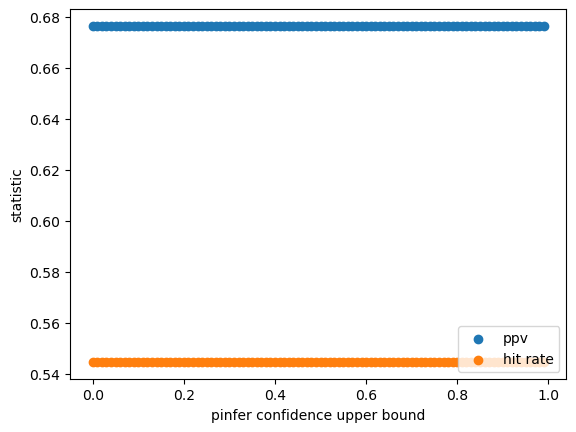

In [334]:
cutoffs = np.arange(0,1,.01)
ppvs, hit_rates = [], []
for cutoff in cutoffs:
#     pinfer_criteria = (df.clean_confidence.between(.8,.81)) #& (df.pinfer_confidence == 0)
#     clean_criteria = (df.clean_confidence.between(.3,.4)) & (df.pinfer_confidence != 1)

    pinfer_criteria = (df.pinfer_confidence.between(1,1))
    clean_criteria = (df.clean_confidence.between(.3,.31)) #& (df.pinfer_confidence != 1)
    
    ppv, hit_rate = eval_strategy(df, clean_criteria, pinfer_criteria)
    ppvs.append(ppv)
    hit_rates.append(hit_rate)
fig, ax = plt.subplots()

ax.scatter(cutoffs, ppvs, label = "ppv")
ax.scatter(cutoffs, hit_rates, label = "hit rate")

#
plt.xlabel("pinfer confidence upper bound")
plt.ylabel("statistic")
plt.legend(loc = "lower right")

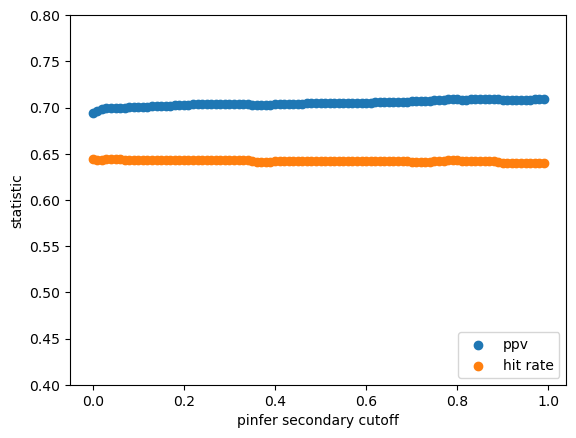

In [273]:
plot_cutoffs_secondary_pinfer(np.arange(0,1,.01))

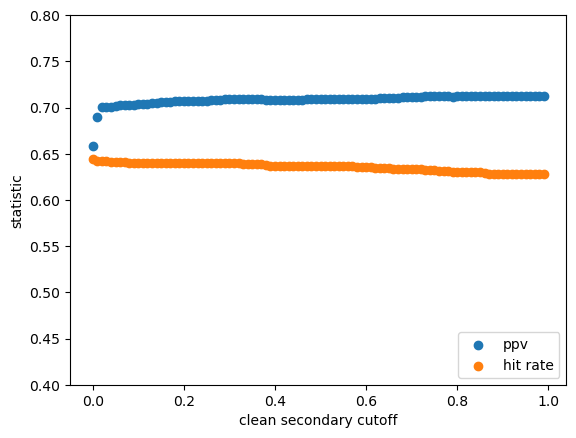

In [253]:
plot_cutoffs_secondary_clean(np.arange(0,1,.01))

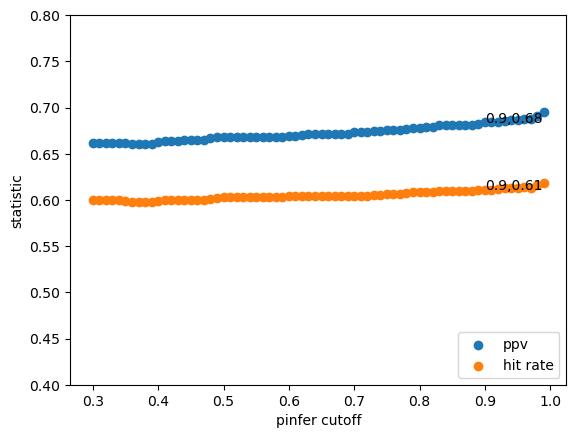

In [244]:
plot_cutoffs_pinfer(np.arange(.3,1,.01))

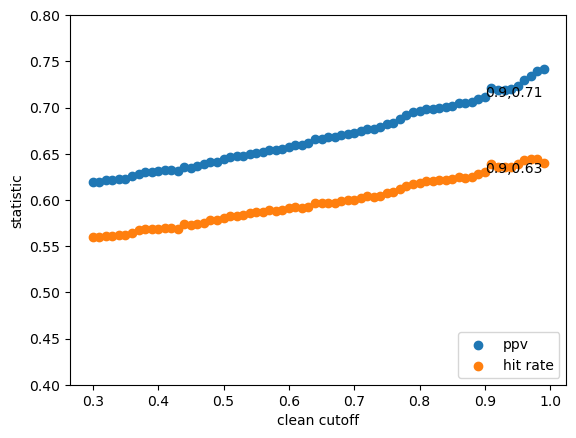

In [246]:
plot_cutoffs_clean(np.arange(.3,1,.01))

In [262]:
eval_strategy(df, clean_highconf_ormoreconf, pinfer_moreconf)

(0.7088122605363985, 0.6429192006950478)

In [263]:
eval_strategy(df, clean_highconf_orwaymoreconf, pinfer_second_choice)

(0.7090558766859345, 0.6394439617723718)

In [179]:
eval_strategy(df, clean_second_choice, pinfer_fullconf)

111 108 106 103 92
927 863 805 771 627
0 37 96 527
971 911 874 719


(0.6926782273603083, 0.6246741963509991)

In [180]:
eval_strategy(df, clean_highconf_ormoreconf, pinfer_moreconf)

452 433 420 405 259
437 424 405 390 365
0 16 52 296
857 825 795 624


(0.7019122609673791, 0.5421372719374457)

In [181]:
eval_strategy(df, clean_highconf, pinfer_waymoreconf)

473 456 441 419 260
431 418 400 385 360
0 16 51 291
874 841 804 620


(0.6858407079646017, 0.5386620330147698)

In [113]:
df[(df.pinfer_confidence != 1) & (df.clean_confidence > .01)]

,Query,EC_label_x,EC_x,clean_confidence,EC_label_y,EC_y,pinfer_confidence
10,A0A0H2US87,4.3.99.-,3.4.22.45,0.1438,0.0.0.0,0.0.0.0,0.00
13,A0A0H3JNB0,2.4.1.-,2.4.1.53,0.0542,2.4.1.-,2.4.1.-,0.90
16,A0A0H3JUU7,6.3.5.13,6.3.5.13,0.9963,6.3.5.13,6.3.-.-,0.89
18,A0A0K2JL82,4.3.99.5,5.5.1.2,0.6574,0.0.0.0,0.0.0.0,0.00
23,A0A0X1KHF9,2.7.9.6,2.7.3.13,0.0491,0.0.0.0,0.0.0.0,0.00
...,...,...,...,...,...,...,...
3632,Q9X108,3.2.1.86,3.2.1.86,0.8696,3.2.1.86,3.-.-.-,0.75
3646,Q9XGM3,3.2.2.6,3.2.2.6,0.6104,0.0.0.0,0.0.0.0,0.00
3653,Q9Y006,3.4.23.39,3.4.23.39,0.9986,0.0.0.0,0.0.0.0,0.00
3717,T1WGN1,3.2.1.96,3.2.1.96,0.3205,0.0.0.0,0.0.0.0,0.00


# visualize stats

In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

In [188]:
allstats_melt = pd.concat([uniprot_stats_c_summary, uniprot_stats_p_summary]).sort_values(["group","eclevel_method"])

In [190]:
group2desc = {"1": "Oxidoreductases", "2": "Transferases", "3": "Hydrolases", "4": "Lyases", "5": "Isomerases", "6": "Ligases", "7": "Translocases"}

In [191]:
sns.set(style="ticks",                   # The 'ticks' style
        rc={"figure.figsize": (9, 6),      # width = 6, height = 9
            "figure.facecolor": "ivory",  # Figure colour
            "axes.facecolor": "ivory"})  # Axes colour

done
done
done
done
done
done
done


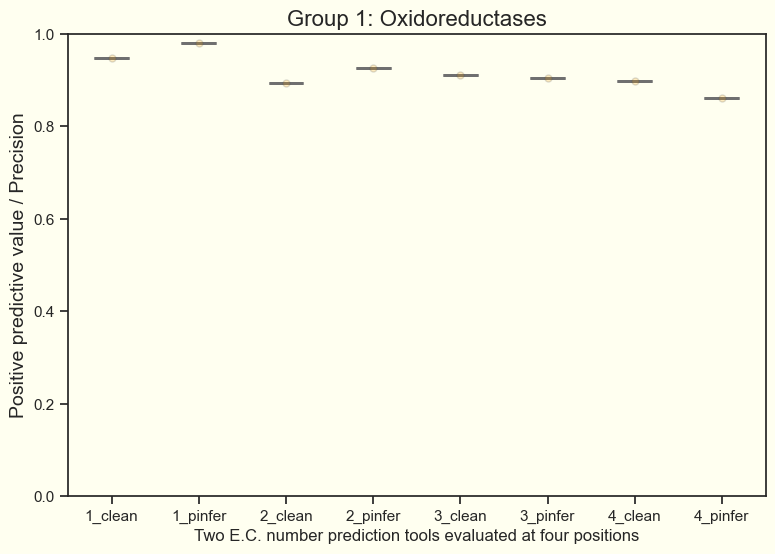

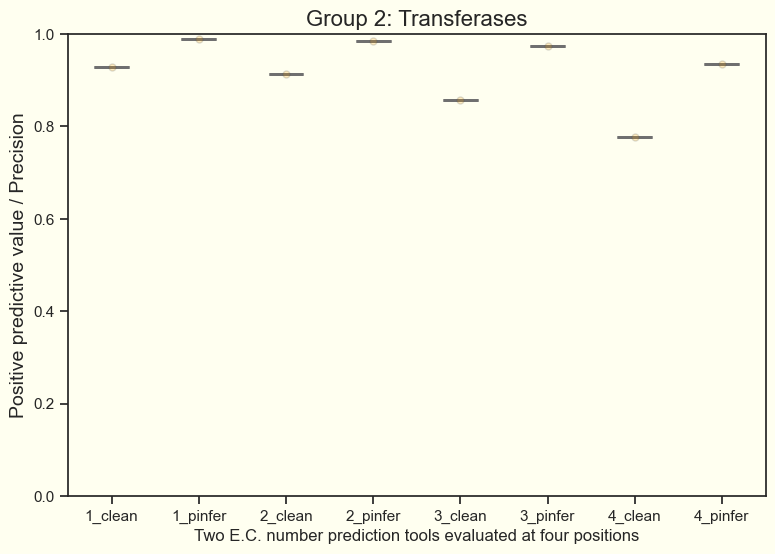

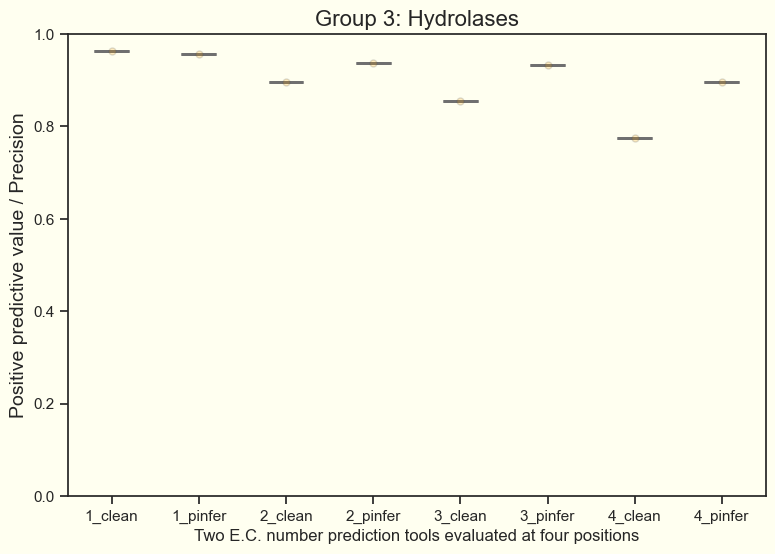

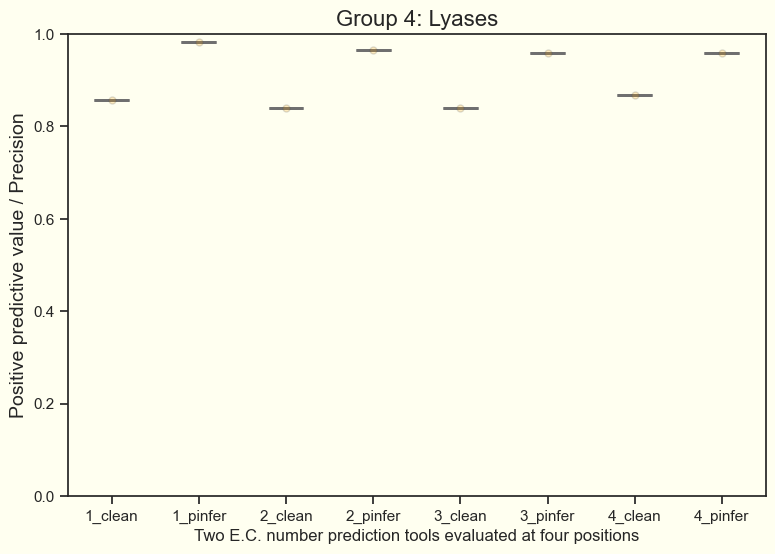

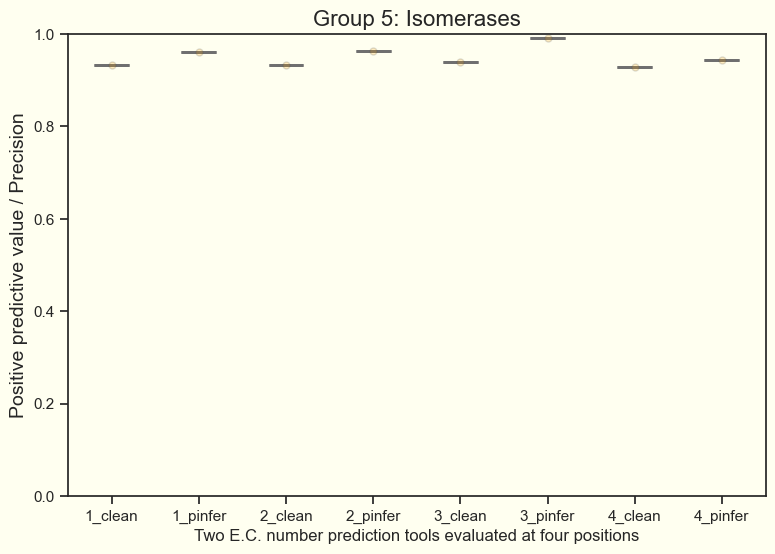

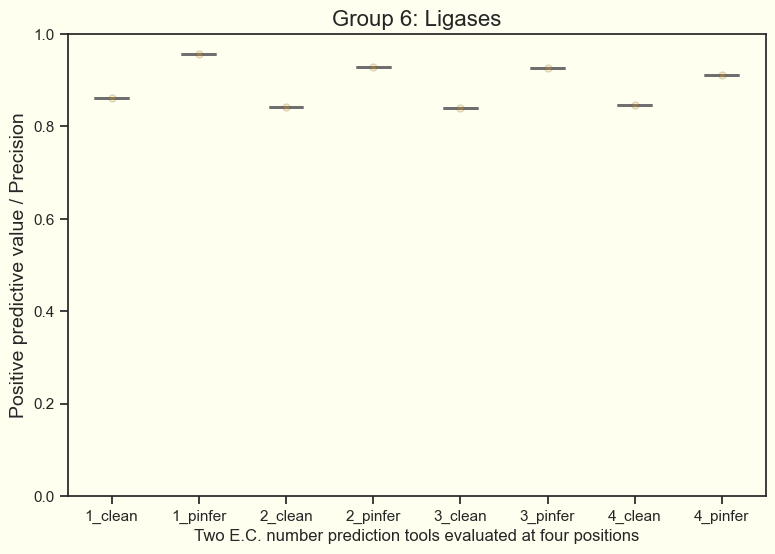

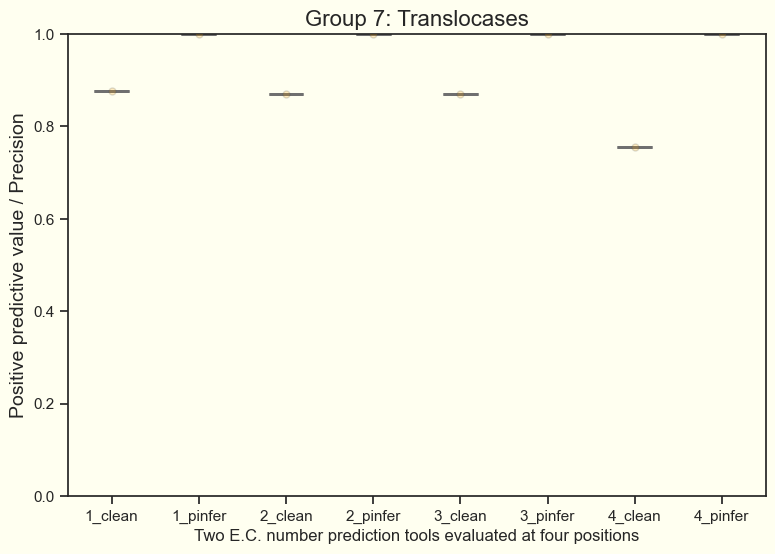

In [202]:
# ppv
for group in range(1,8):
    group = str(group)
    plt.figure()
    group_ppv = allstats_melt[allstats_melt.group == group]
    b = sns.boxplot(data = group_ppv, 
                    x = "eclevel_method", 
                    y = "ppv",
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers)
    # Strip plot
    b = sns.stripplot(data = group_ppv,          
                      x = "eclevel_method",      # x axis column from data
                      y = "ppv",      # y axis column from data
                      color = "orange", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.2)       # Makes them transparent

    b.set_ylabel("Positive predictive value / Precision", fontsize = 14)
    b.set_xlabel("Two E.C. number prediction tools evaluated at four positions", fontsize = 12)
    desc = group2desc[group]
    b.set_title(f"Group {group}: {desc}", fontsize = 16)
    # Remove axis spines
    #sns.despine(offset = 5, trim = True)


    # Show the plot
    b.set_ylim(0,1)
    b.get_figure();
    #plt.close(b.get_figure())
    print("done")

done
done
done
done
done
done
done


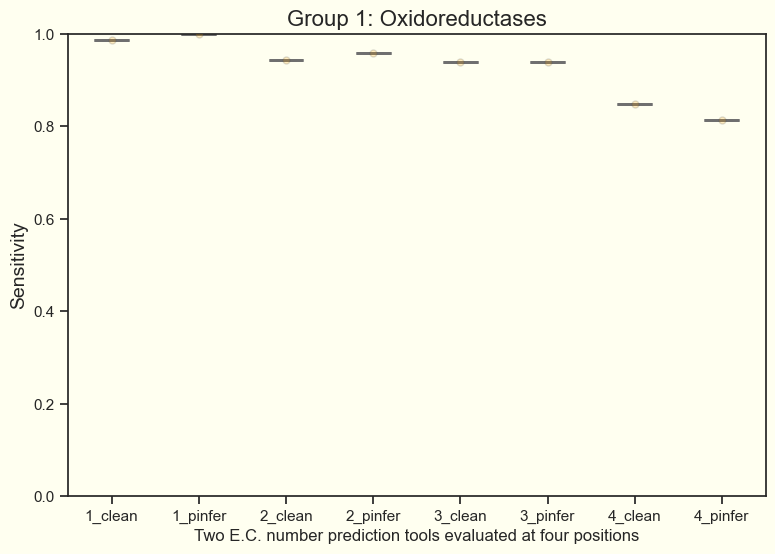

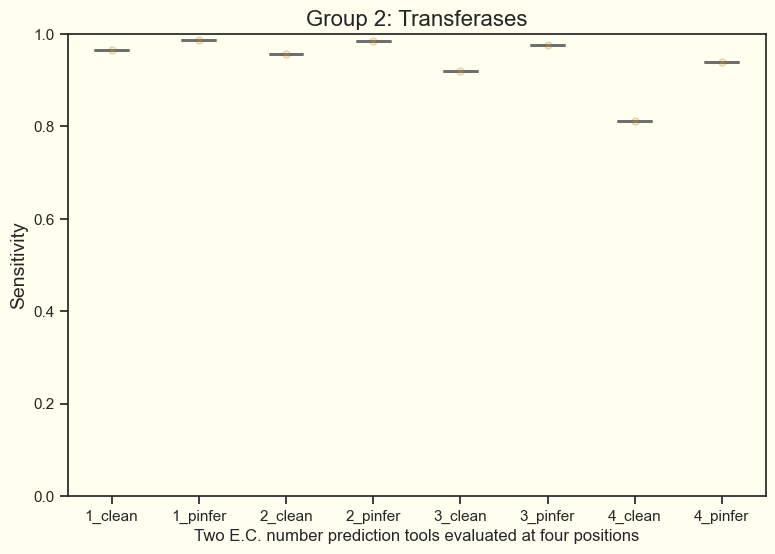

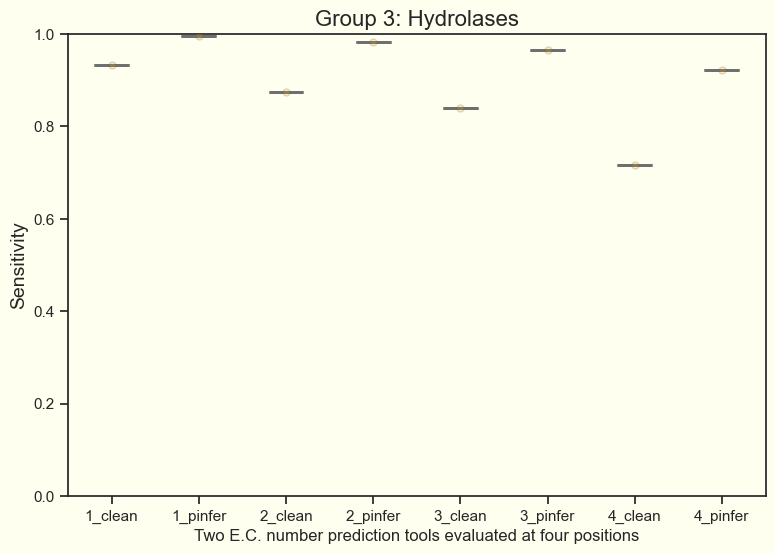

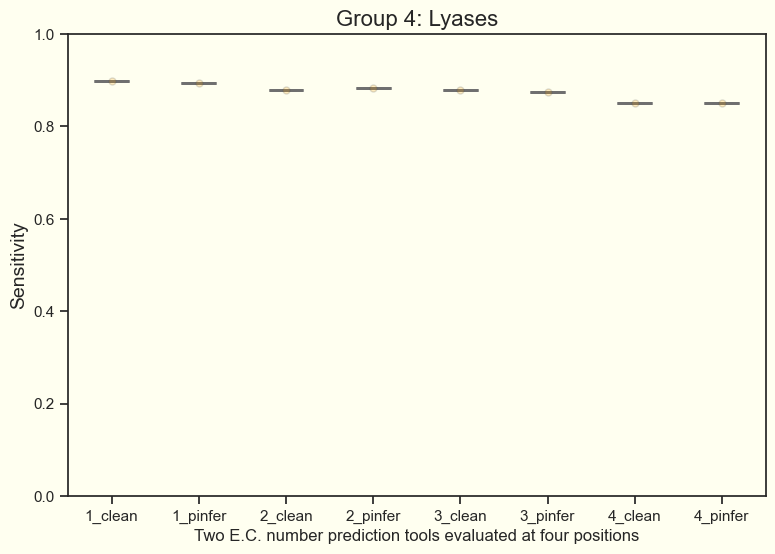

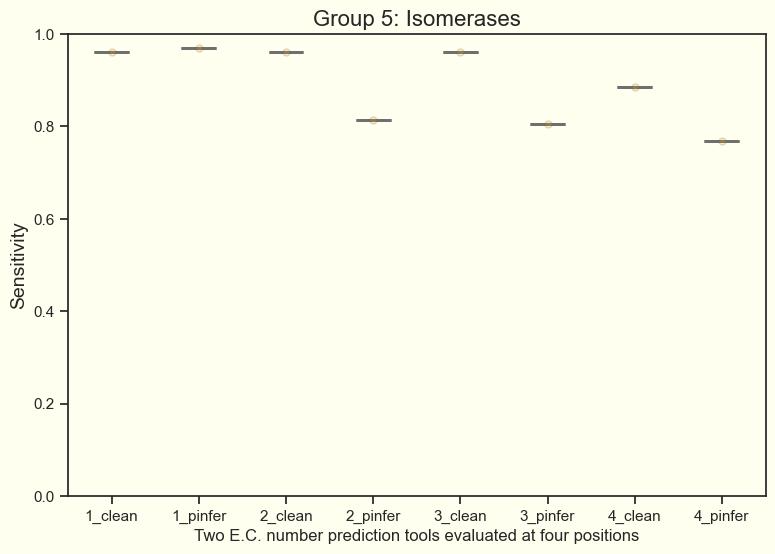

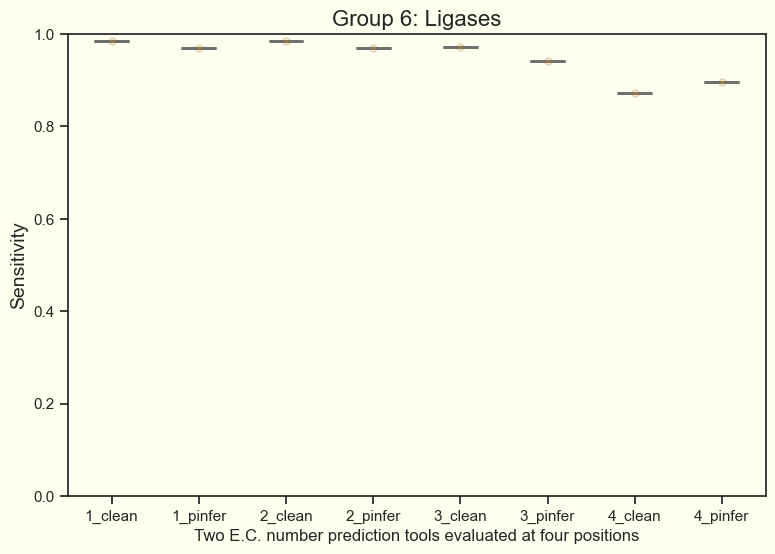

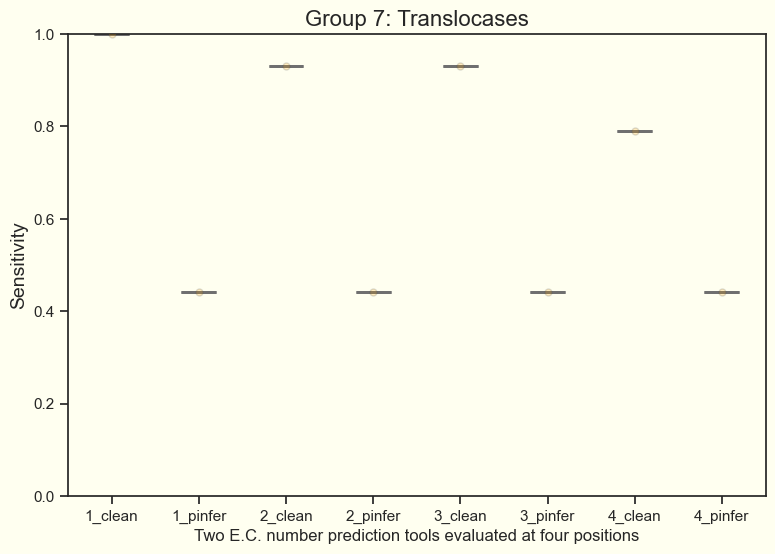

In [203]:
# sensitivity
for group in range(1,8):
    group = str(group)
    plt.figure()
    group_ppv = allstats_melt[allstats_melt.group == group]
    b = sns.boxplot(data = group_ppv, 
                    x = "eclevel_method", 
                    y = "sensitivity",
                    width = 0.4,        # The width of the boxes
                    color = "skyblue",  # Box colour
                    linewidth = 2,      # Thickness of the box lines
                    showfliers = False)  # Sop showing the fliers)
    # Strip plot
    b = sns.stripplot(data = group_ppv,          
                      x = "eclevel_method",      # x axis column from data
                      y = "sensitivity",      # y axis column from data
                      color = "orange", # Colours the dots
                      linewidth = 1,     # Dot outline width
                      alpha = 0.2)       # Makes them transparent

    b.set_ylabel("Sensitivity", fontsize = 14)
    b.set_xlabel("Two E.C. number prediction tools evaluated at four positions", fontsize = 12)
    desc = group2desc[group]
    b.set_title(f"Group {group}: {desc}", fontsize = 16)
    # Remove axis spines
    # sns.despine(offset = 5, trim = True)


    # Show the plot
    b.set_ylim(0,1)
    b.get_figure();
    #plt.close(b.get_figure())
    print("done")